In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
scratch = "/pscratch/sd/t/timothys"

In [4]:
varnames = [
    "surface_pressure",
    "10m_zonal_wind",
    "10m_meridional_wind",
    "2m_temperature",
    "500hpa_geopotential_height",
    "250hpa_zonal_wind",
    "250hpa_meridional_wind",
    "850hpa_temperature",
    "850hpa_specific_humidity",
]

In [5]:
nice_names = {
    "surface_pressure": "Surface Pressure (Pa)",
    "2m_temperature": "2m Temperature (\u00B0C)",
    "10m_zonal_wind": "10m Zonal Wind (m s$^{-1}$)",
    "10m_meridional_wind": "10m Meridional Wind (m s$^{-1}$)",
    "500hpa_geopotential_height": "500 hPa Geopotential Height (m)",
    "850hpa_temperature": "850 hPa Temperature (\u00B0C)",
    "850hpa_specific_humidity": "850 hPa Specific Humidity (kg kg$^{-1}$)",
    "250hpa_zonal_wind": "250 hPa Zonal Wind (m s$^{-1}$)",
    "250hpa_meridional_wind": "250 hPa Meridional Wind (m s$^{-1}$)",
}

In [6]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    for label, xds in dsdict.items():
        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        df = plotme.to_dataframe().reset_index()
        color=None
        if "HRRR" in label:
            color = "gray"
        elif "GFS" in label:
            color = "black"
                
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            color=color,
            legend=False,
            **kwargs,
        )
    dt = 24
    if sel is not None:
        if sel.get("fhr", None) is not None:
            dt = 6
    last_time = 240 if dt == 24 else 48
    xticks = np.arange(0, last_time+1, dt)
    xticklabels = xticks//24 if dt == 24 else xticks #plotme.fhr.values
    units = "days" if dt == 24 else "hours"
    #xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.text(.05, .9, nice_names[varname], transform=ax.transAxes, ha="left", va="center")
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel=f"Lead Time ({units})" if ax.get_subplotspec().is_last_row() else "",
        title="",#nice_names[varname],# if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
        xticklabels=xticklabels,
    )
    #ax.legend(frameon=False)

In [7]:
def plot_error(dsdict, vnames=varnames, **kwargs):

    nvars = len(vnames)
    nrows = 2
    ncols = np.ceil(nvars / nrows).astype(int)
    fig, axs = plt.subplots(
        nrows,
        ncols,
        figsize=(5*ncols, 4*nrows),
        constrained_layout=True,
        sharex=True,
    )
        
    #for varname, ax in zip(vnames, axs.flatten()):
    #    single_plot(ax=ax, dsdict=dsdict, varname=varname, **kwargs)
    for varname, ax in zip(vnames[:4], axs.flatten()):
        single_plot(ax=ax, dsdict=dsdict, varname=varname, **kwargs)
    for varname, ax in zip(vnames[-5:], axs.flatten()[-5:]):
        single_plot(ax=ax, dsdict=dsdict, varname=varname, **kwargs)
        
    handles, labels = axs[0, 0].get_legend_handles_labels()
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncols=len(labels),
        frameon=False,
    )
    for line in legend.get_lines():
        line.set_linewidth(16)
    plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])
    return fig, axs

In [8]:
def make_dataset(workpath, vnames=varnames):
    return xr.Dataset(
        {
            varname: xr.load_dataset(f"{workpath}/{varname}.nc")[metric]
            for varname in vnames
        }
    )

## Compare Num. ICs

In [9]:
metric = "MAE"

nic = {
    "2 IC": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/obs-val"),
    "1 IC": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/nic/sic/inference-validation/obs-val"),
    "HRRR": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/hrrr-forecasts-vs-hrrr-analysis/trim10/obs-val"),
    #"GFS": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-hrrr-analysis/obs-val"),
}

### CONUS

/tmp/ipykernel_1982922/1858440733.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


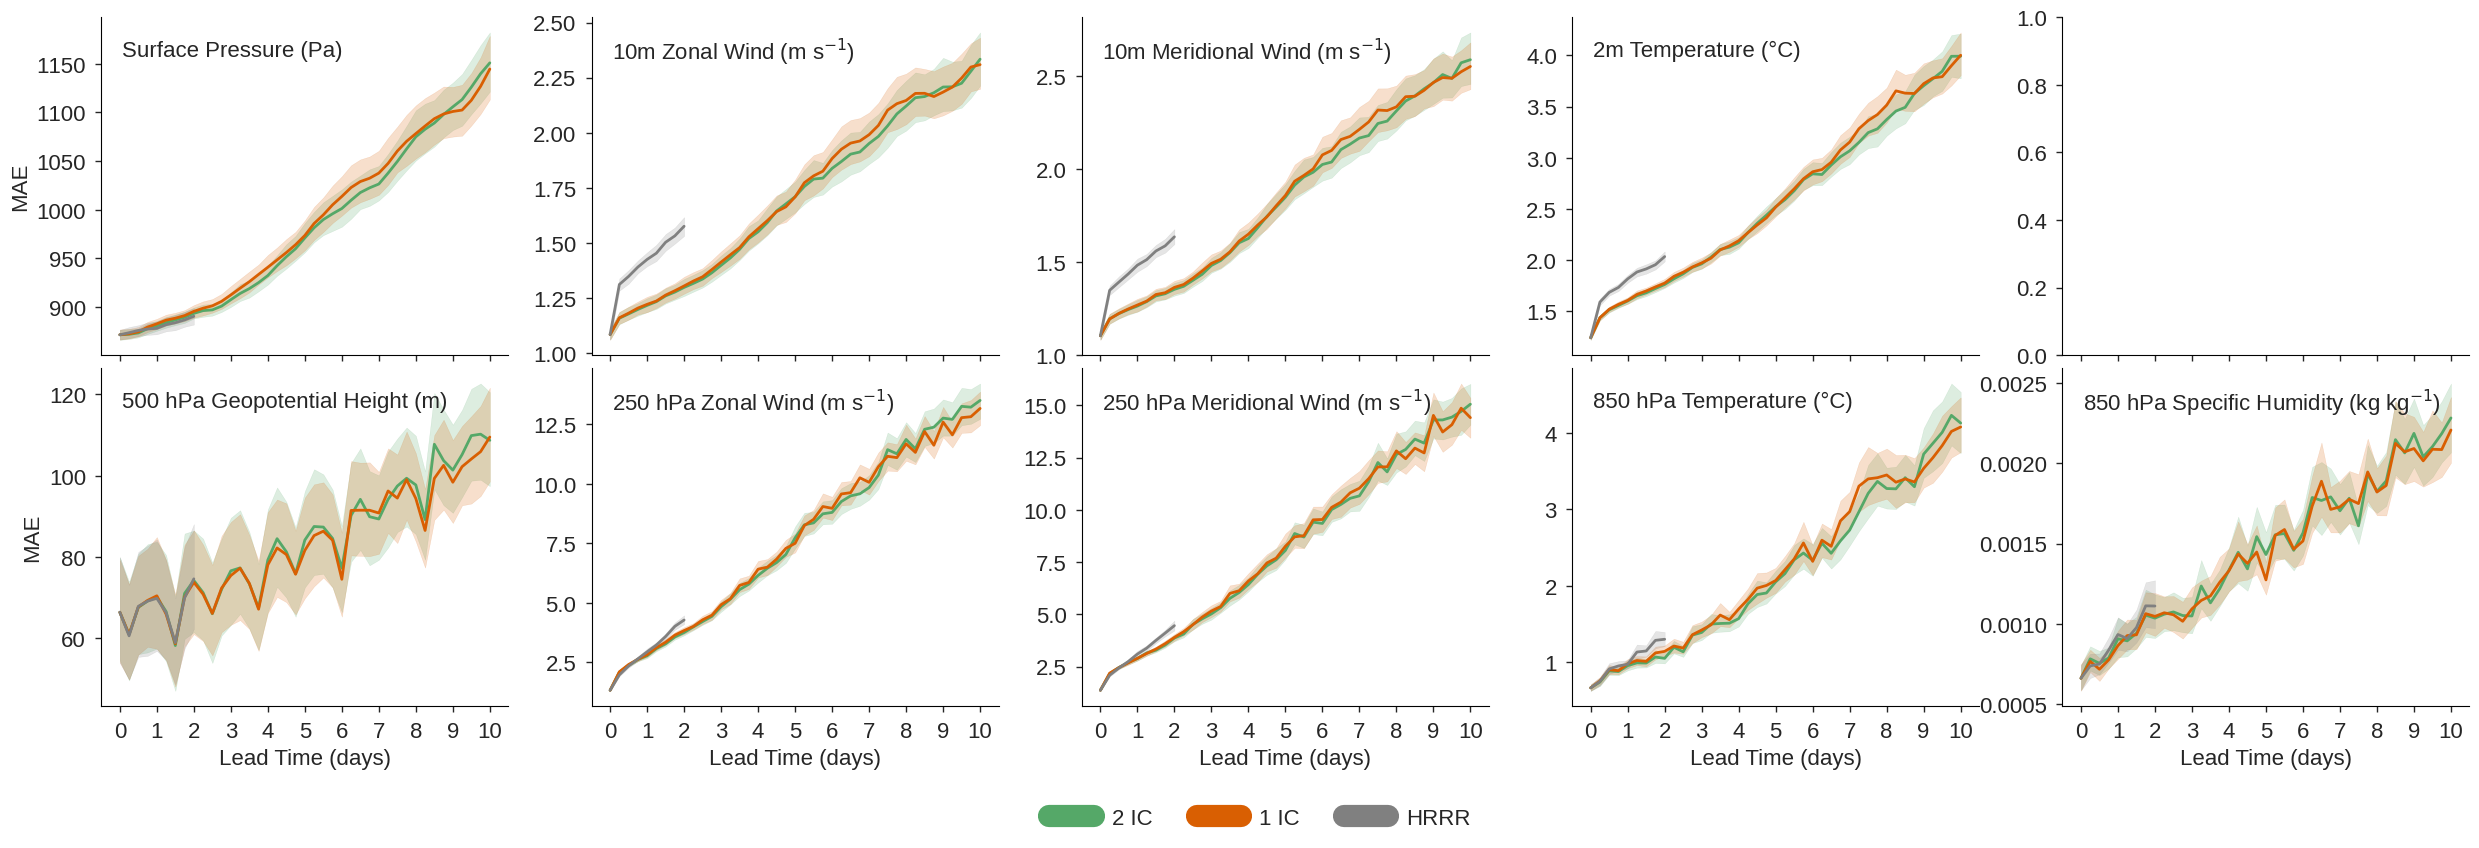

In [10]:
fig, axs = plot_error(nic)

/tmp/ipykernel_1982922/1858440733.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


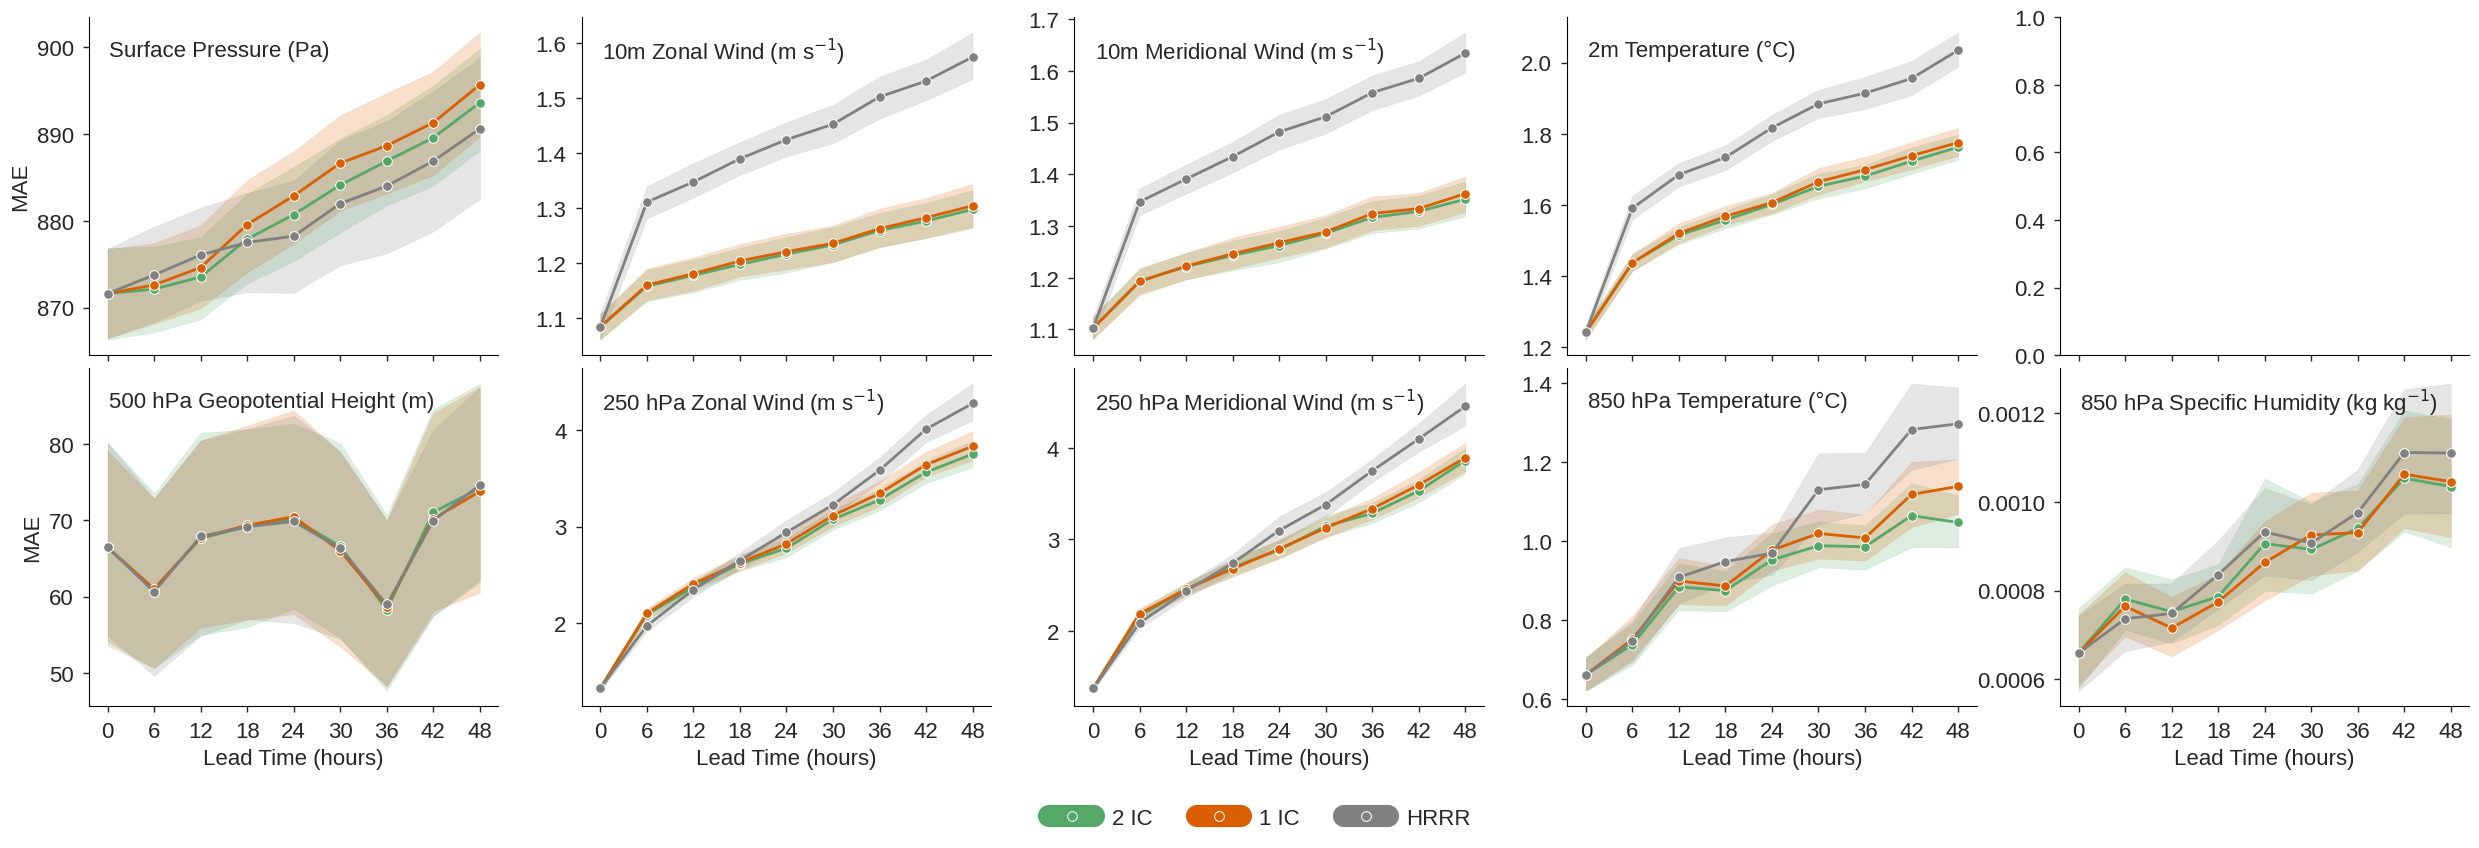

In [11]:
fig, axs = plot_error(nic, sel={"fhr": slice(49)}, marker="o")

### Global

In [12]:
nic = {
    "2 IC": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/obs-val-global"),
    "1 IC": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/nic/sic/inference-validation/obs-val-global"),
    "GFS": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-val"),
}

/tmp/ipykernel_1982922/1858440733.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


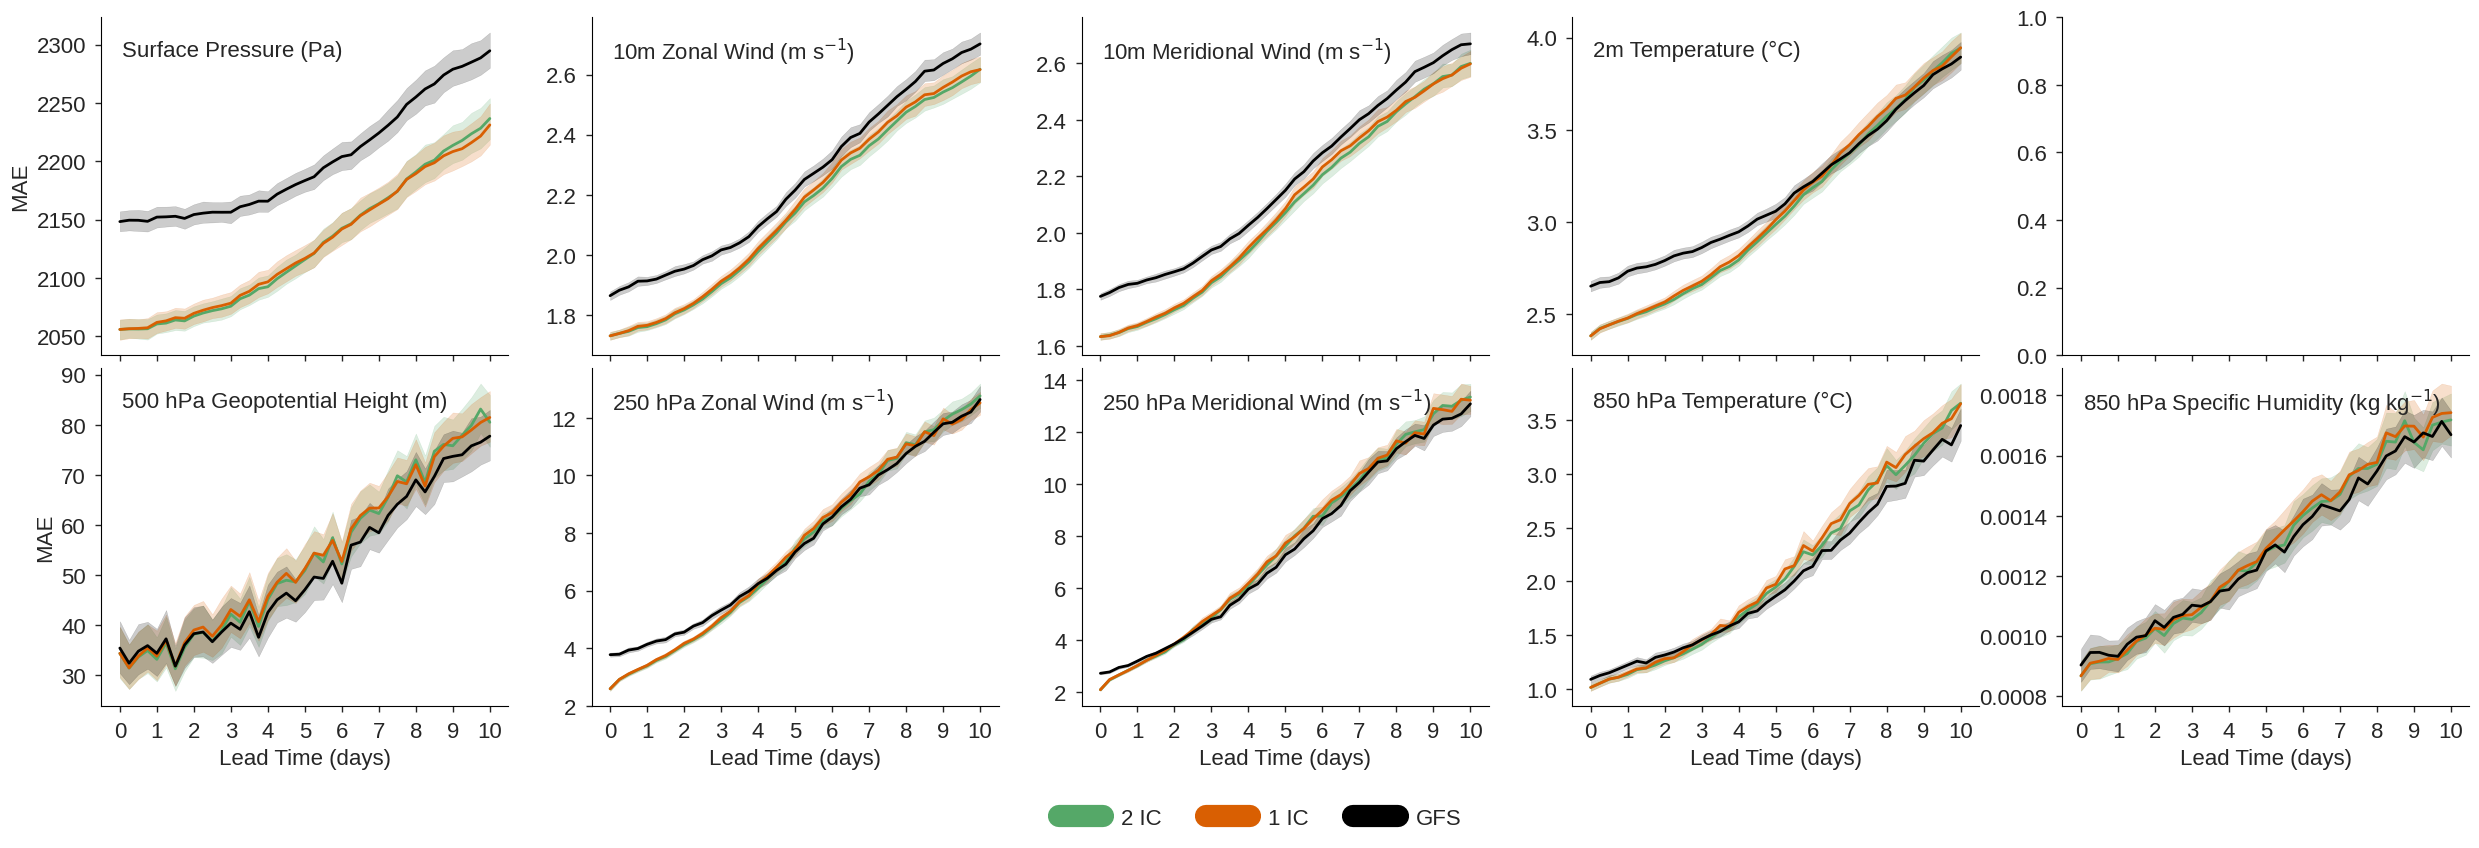

In [13]:
fig, axs = plot_error(nic)

/tmp/ipykernel_1982922/1858440733.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


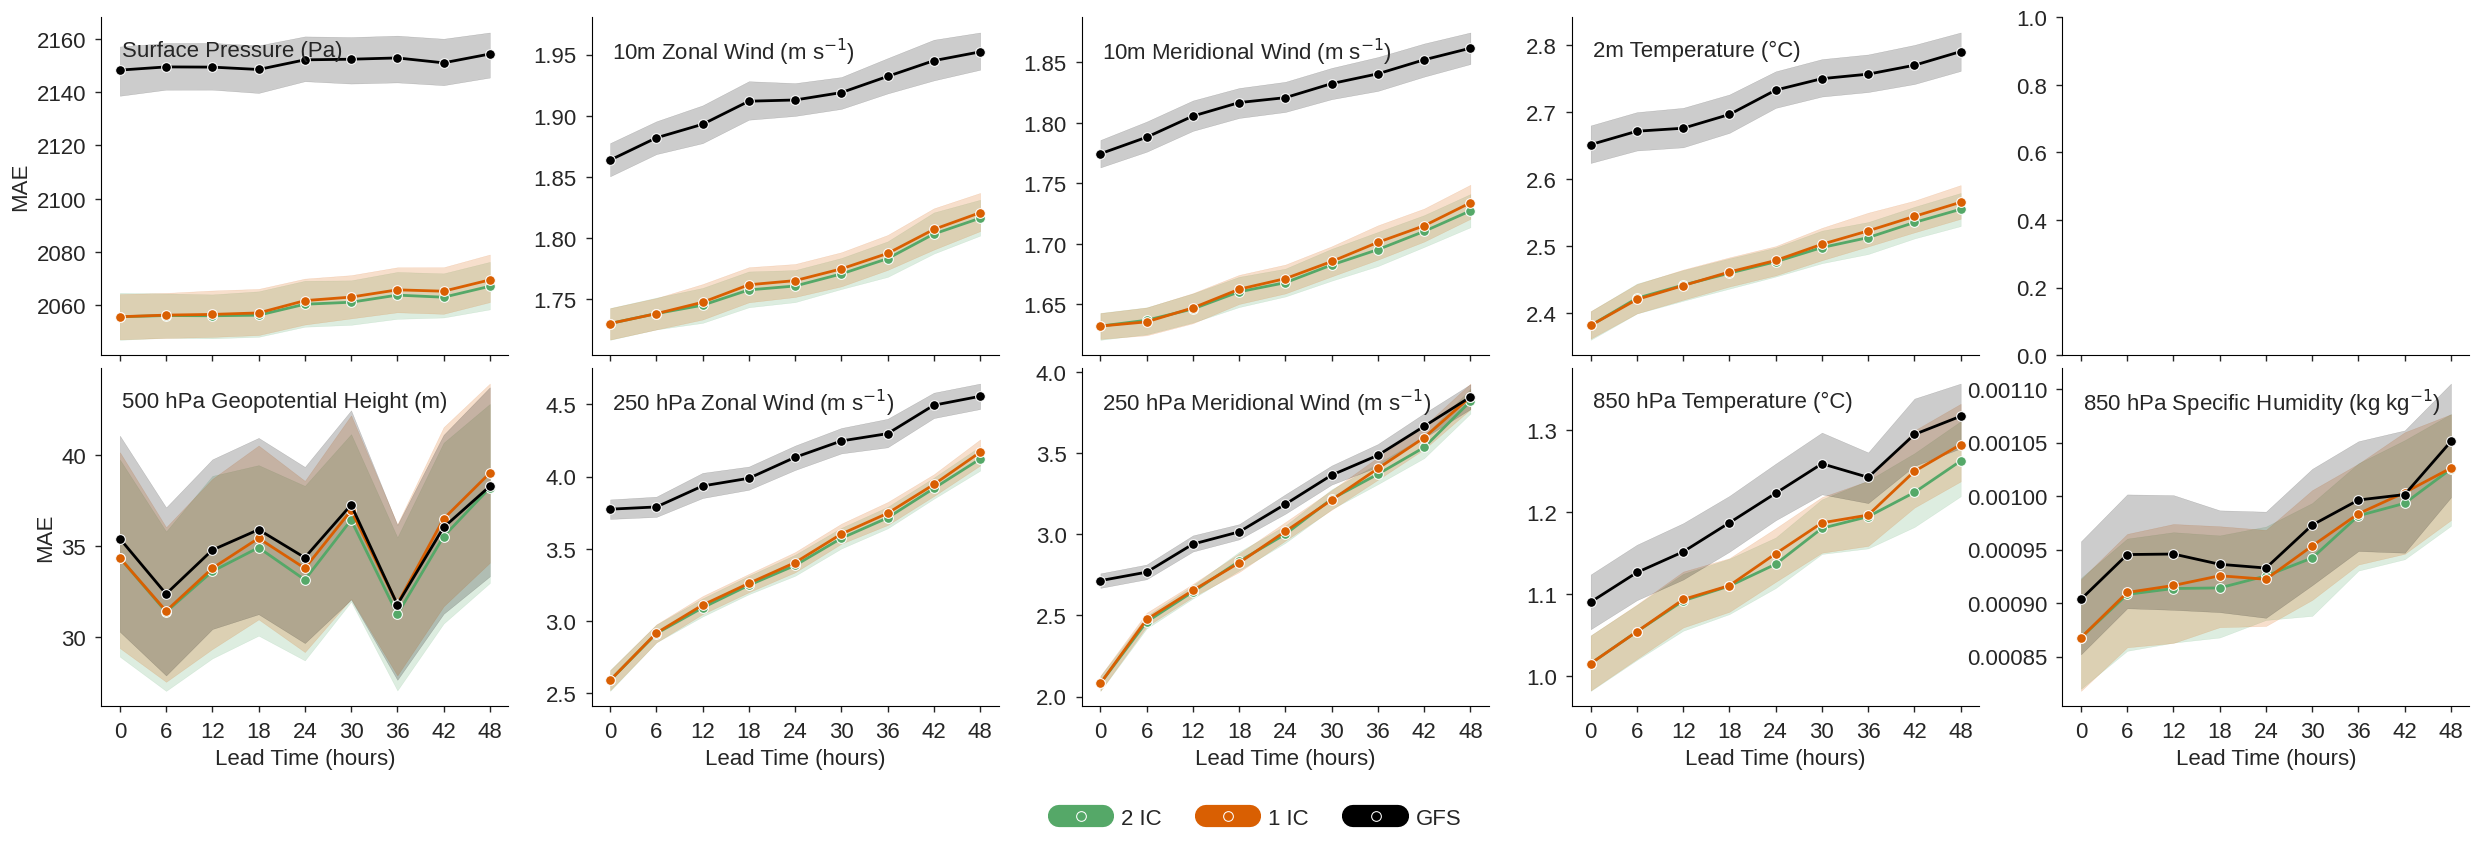

In [14]:
fig, axs = plot_error(nic, sel={"fhr": slice(49)}, marker="o")

## Num. Training Steps

### CONUS

In [15]:
metric = "RMSE"

steps = {
    "30k": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/obs-val"),
    "60k": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/training-steps/steps060k/inference-validation/obs-val"),
    "HRRR": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/hrrr-forecasts-vs-hrrr-analysis/trim10/obs-val"),
    #"GFS": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-hrrr-analysis/obs-val"),
}

/tmp/ipykernel_1982922/1858440733.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


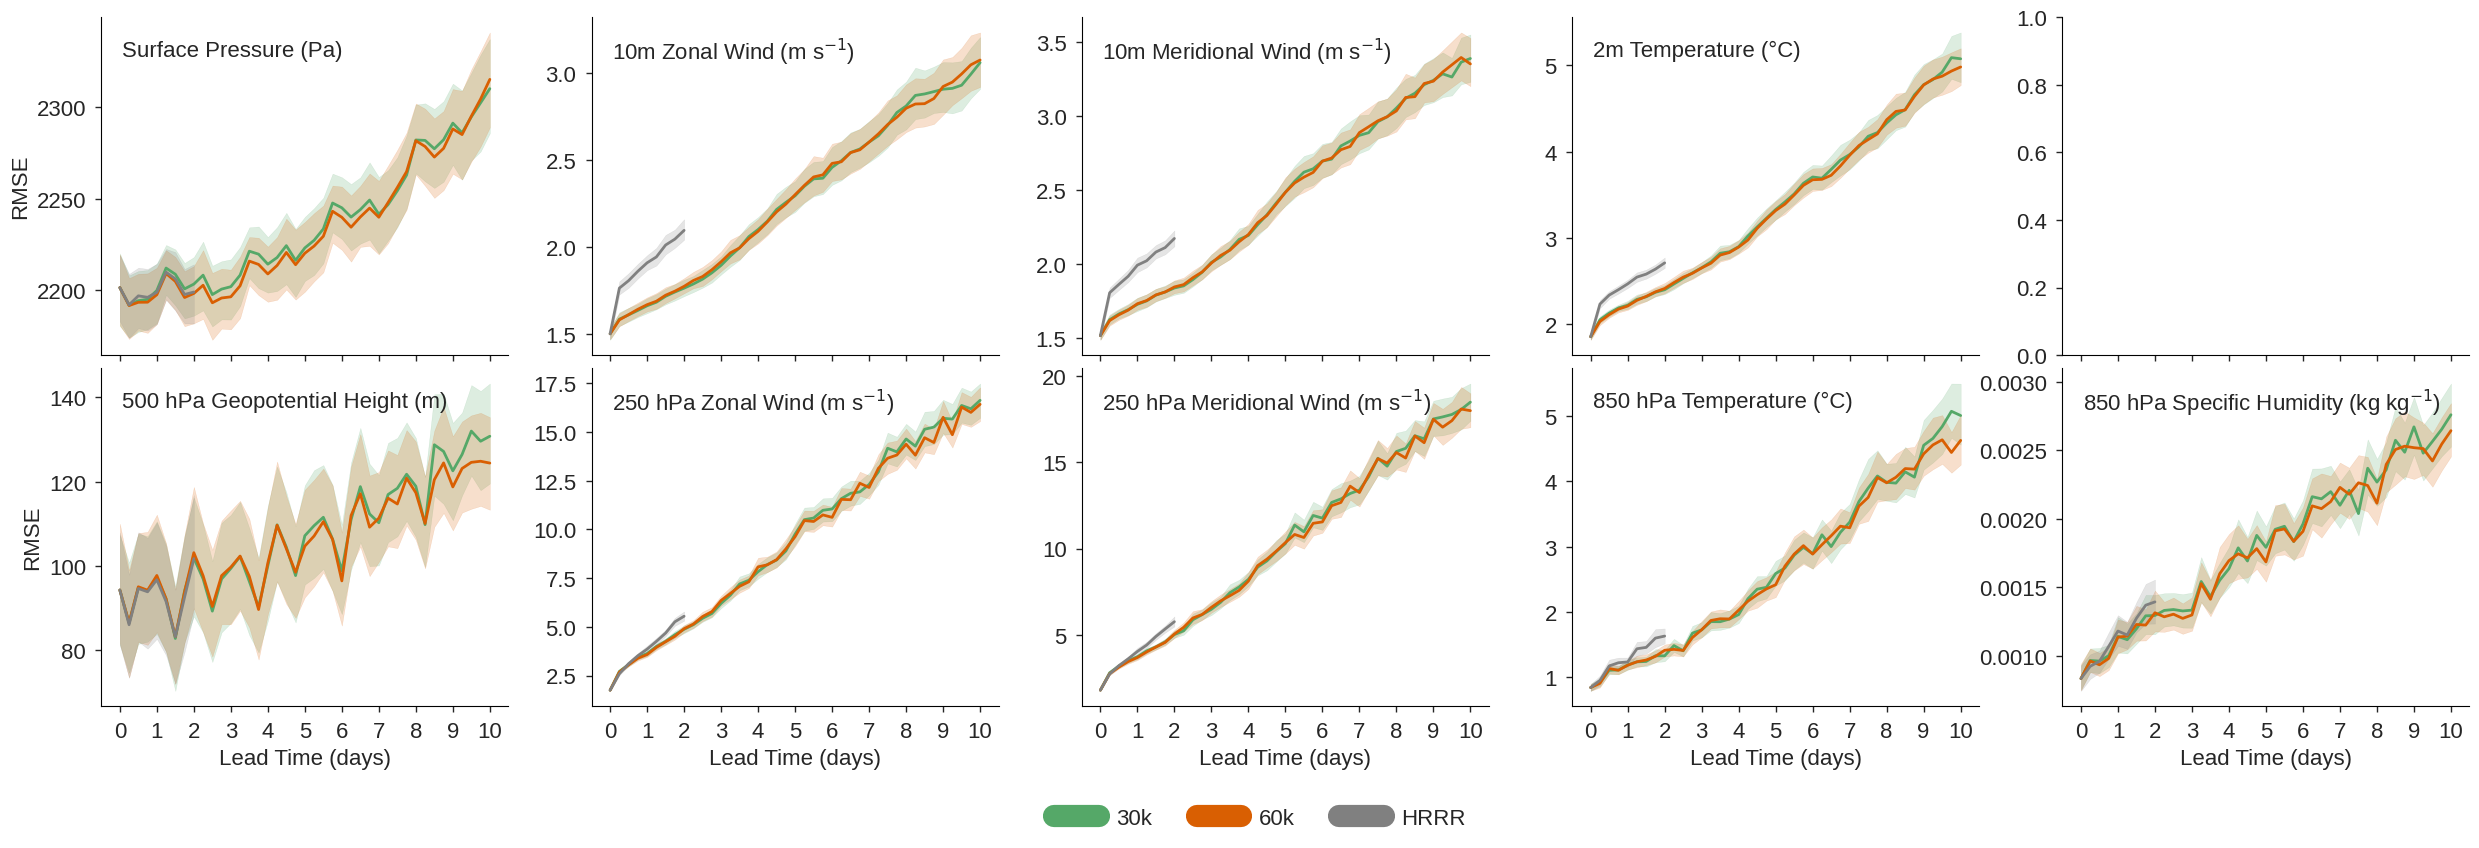

In [16]:
fig, axs = plot_error(steps)

/tmp/ipykernel_1982922/1858440733.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


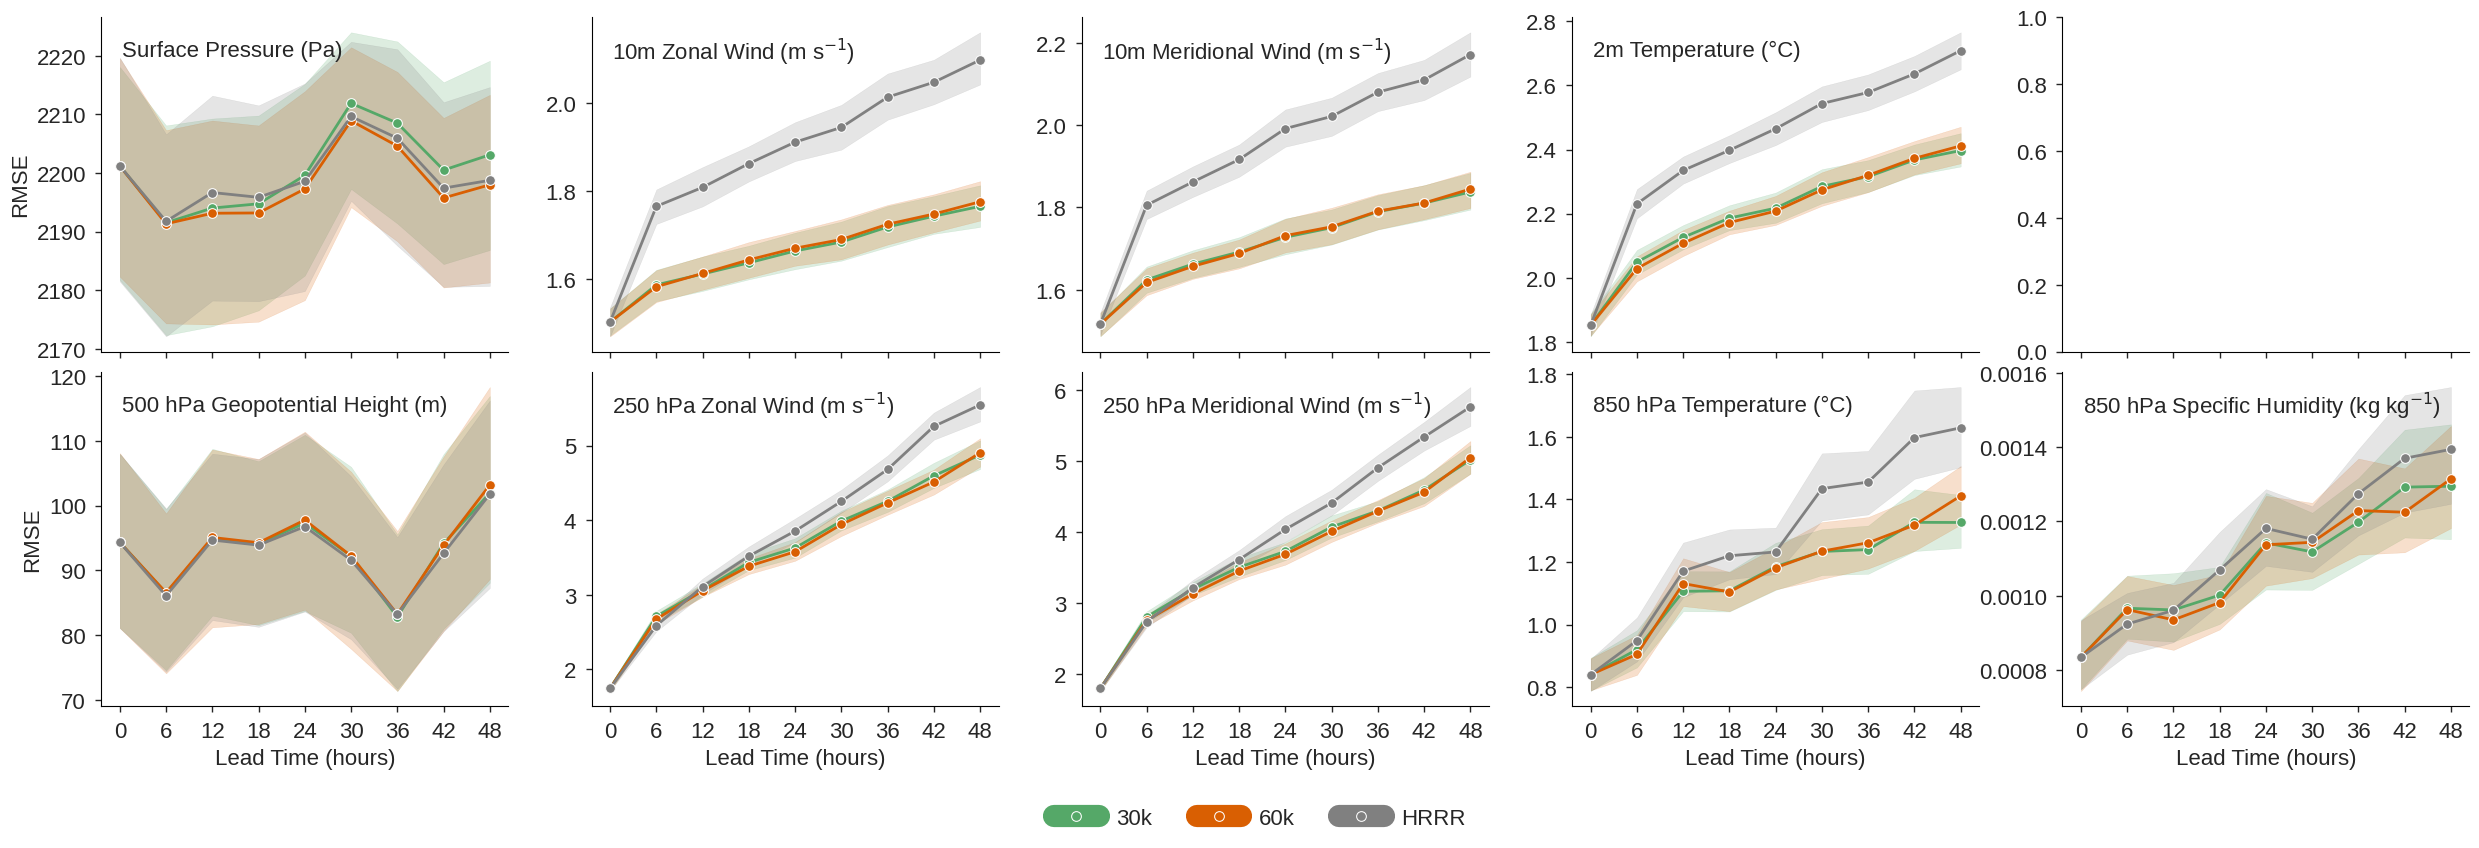

In [17]:
fig, axs = plot_error(steps, sel={"fhr": slice(49)}, marker="o")

### Global

In [18]:
metric = "RMSE"

steps = {
    "30k": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/obs-val-global"),
    "60k": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/training-steps/steps060k/inference-validation/obs-val-global"),
    "GFS": make_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-val"),
}

/tmp/ipykernel_1982922/1858440733.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


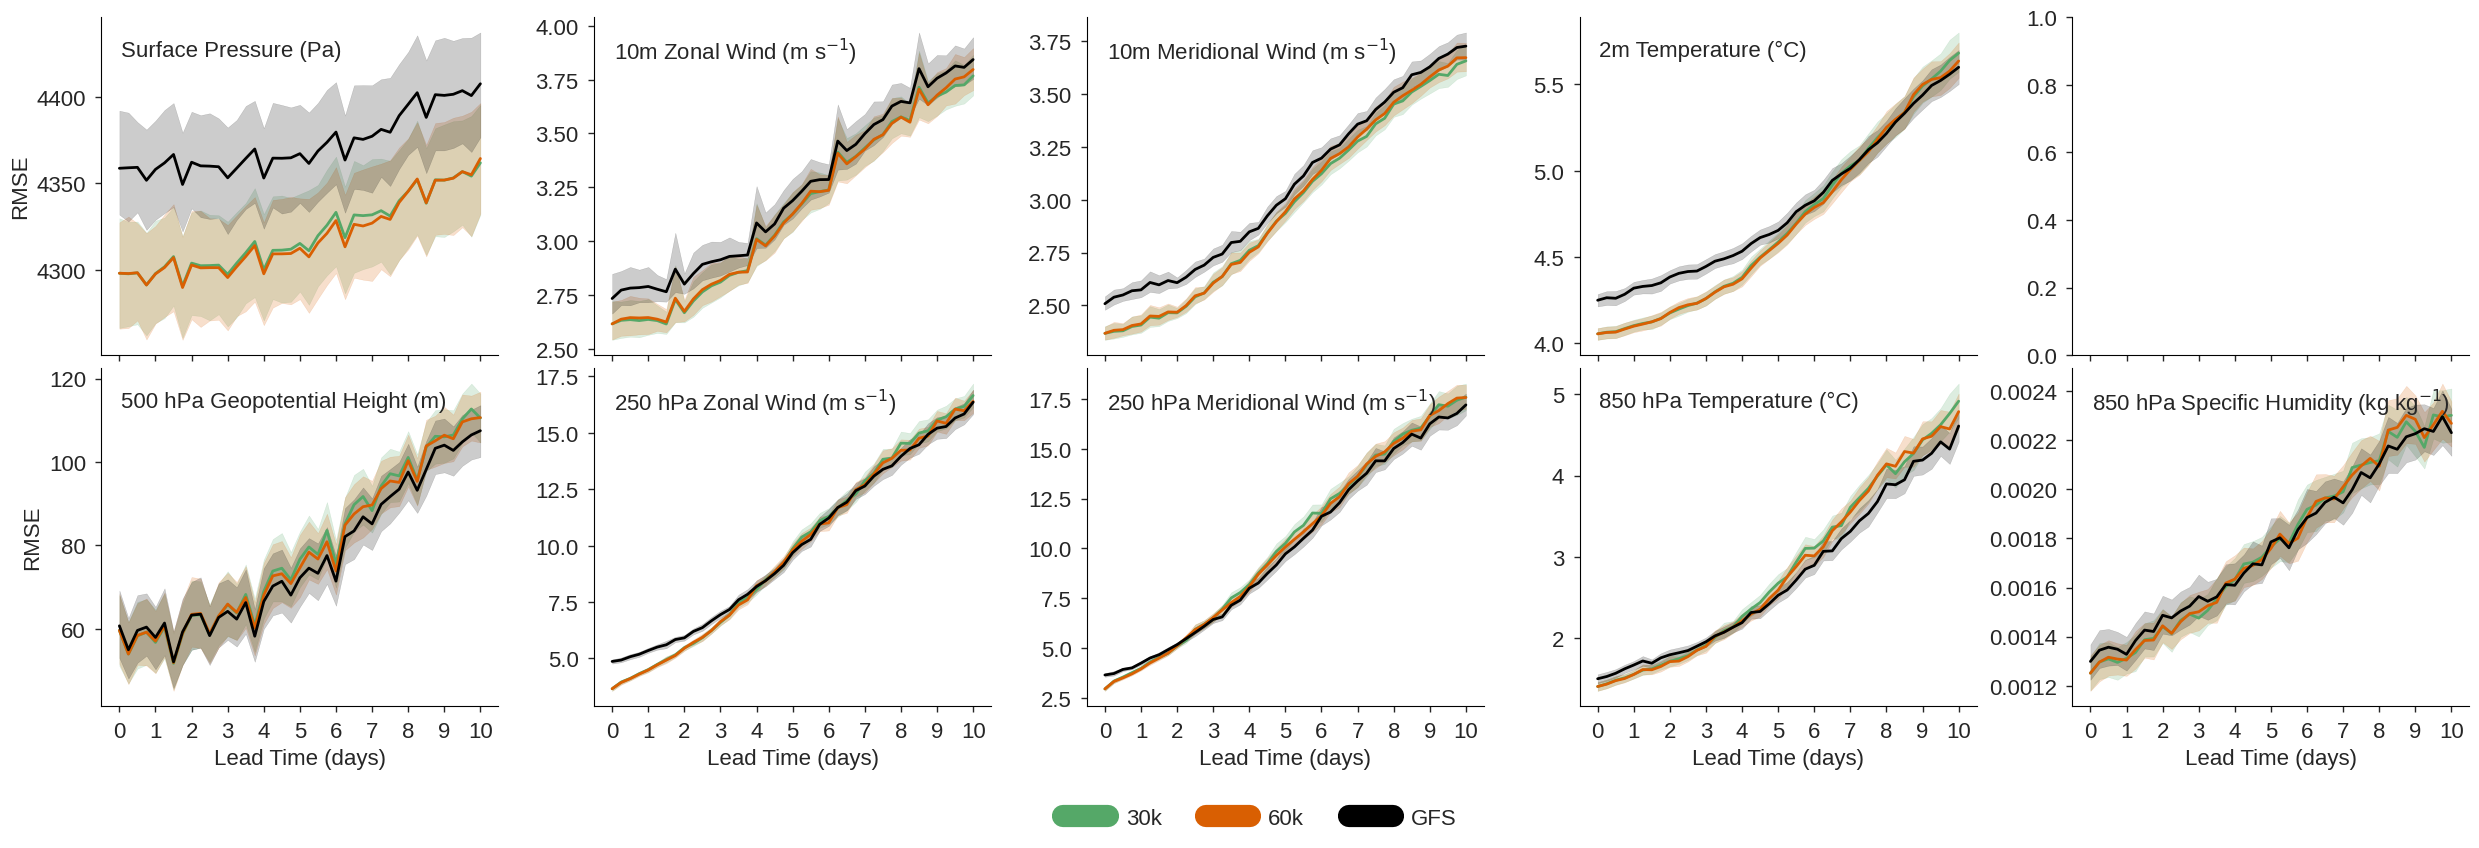

In [19]:
fig, axs = plot_error(steps)

In [ ]:
fig, axs = plot_error(steps, sel={"fhr": slice(49)}, marker="o")